In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import numpy as np
from utils import *


In [26]:
class BCM_Model(nn.Module):
    def __init__(self, n_in, n_units):
        super().__init__()
        # learnable params
        self.weights = torch.normal(mean=0, std=(2 / n_in)**(1/2),size=(n_units, n_in), dtype=torch.float64) # http://arxiv.org/abs/1502.01852
        self.threshold = torch.zeros(n_units)

        self.act = nn.ReLU() ## 
        slope = 2.0
        self.mod =  nn.Tanh()

        # tracking
        self.selectivity = []
        self.activations = []
        self.threshold_trace = []
    
    def update(self, x, eps=0.5, dt=0.01):

        # update threshold
        y = torch.mm(self.weights, x) 
     #  y = self.act(torch.mm(self.weights, x)) # y (n_units, n_batch)

                # calc current threshold 
        cur_threshold = torch.mean(y**2, dim=1) # avg over batch 

        # update threshold using moving avg 
      #  gamma = 0.05
        self.threshold =  torch.mean(y**2, dim=1)#( gamma*self.threshold + (1-gamma) * cur_threshold )# * tau_th
        t  = self.threshold.reshape(-1, 1)
        
        # calc weight update
      #  phi = y * (y - t) 
        slope = 2.0
        phi = self.mod(slope * (y - t)) 
        delta_w =    torch.mm(phi, x.T)   - eps * self.weights
        delta_w /= batch_size # norm update with batchsize

        # update weights
        self.weights += delta_w * dt

        self.weights =  self.weights/torch.linalg.norm(self.weights)
        
        # tracking
        self.selectivity.append(selectivity_metric(y))
        self.threshold_trace.append(self.threshold)
        self.activations.append(torch.mean(y, dim=1)) # append mean over batch

torch.Size([10, 64])
tensor([-2.1425, -2.1536, -2.1403, -2.1522, -2.1276, -2.1506, -2.1657, -2.1570,
        -2.1277, -2.1424], dtype=torch.float64)
torch.Size([10, 64])
tensor([-2.1763, -2.1752, -2.1746, -2.1860, -2.1668, -2.1710, -2.1947, -2.1876,
        -2.1662, -2.1726], dtype=torch.float64)
torch.Size([10, 64])
tensor([-2.1307, -2.1281, -2.1178, -2.1378, -2.1135, -2.1269, -2.1405, -2.1302,
        -2.1106, -2.1255], dtype=torch.float64)
torch.Size([10, 64])
tensor([-2.1550, -2.1479, -2.1541, -2.1617, -2.1384, -2.1496, -2.1658, -2.1554,
        -2.1452, -2.1491], dtype=torch.float64)
torch.Size([10, 64])
tensor([-2.1435, -2.1398, -2.1418, -2.1458, -2.1336, -2.1408, -2.1511, -2.1419,
        -2.1322, -2.1406], dtype=torch.float64)
torch.Size([10, 64])
tensor([-2.1721, -2.1732, -2.1731, -2.1763, -2.1614, -2.1716, -2.1808, -2.1763,
        -2.1683, -2.1722], dtype=torch.float64)


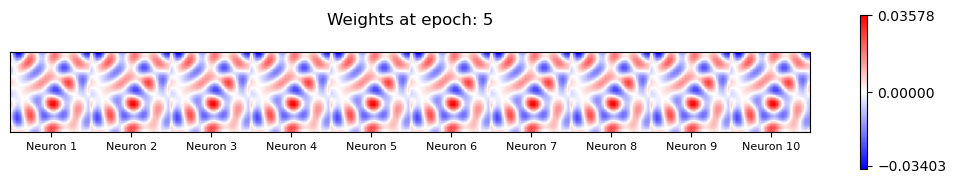

In [27]:
# load data
data_np = np.loadtxt("gratings.csv", delimiter=",")
data = torch.from_numpy(data_np)
n_samples, n_in = data.shape

# from sklearn.datasets import fetch_openml
# data, y = fetch_openml(name='mnist_784', version=1, data_id=None, return_X_y=True)
# data = torch.tensor(data.to_numpy(), dtype=torch.float64)
# data /= 255.
# data -= torch.mean(data, dim=0) # balance data around mean 
# # for mnist eps=0.001 !


# preprocess


print(data.shape)
n_samples, n_in = data.shape

# hps#
n_epochs = 5
n_units = 10
batch_size = 64

model = BCM_Model(n_in, n_units)
#model = BCM_Model_Squadrani(n_in, n_units)

# learning loop
for epoch in range(n_epochs):

    data = data[torch.randperm(n_samples)]  # Shuffle the input data

    # Iterate over all minibatches
    for i in range(n_samples // batch_size):
        minibatch = data[i * batch_size:(i + 1) * batch_size].T # transform to shape (n_in, batch_size)
        model.update(minibatch)
    draw_weights(model.weights, epoch)



In [28]:
model.weights

tensor([[ 5.6921e-05, -2.1023e-02, -3.3797e-02,  ..., -2.4622e-03,
         -2.8417e-03, -1.3621e-03],
        [-1.1694e-04, -2.1004e-02, -3.3790e-02,  ..., -2.5680e-03,
         -2.5614e-03, -1.1429e-03],
        [ 1.9531e-04, -2.1116e-02, -3.3677e-02,  ..., -2.2733e-03,
         -2.7314e-03, -1.3578e-03],
        ...,
        [ 1.5407e-04, -2.1068e-02, -3.3939e-02,  ..., -2.4554e-03,
         -2.7429e-03, -1.4601e-03],
        [-4.3834e-05, -2.1114e-02, -3.3616e-02,  ..., -2.2630e-03,
         -2.9194e-03, -1.4131e-03],
        [-3.9744e-05, -2.0838e-02, -3.3631e-02,  ..., -2.3988e-03,
         -2.8587e-03, -1.1512e-03]], dtype=torch.float64)

### Visual Analysis

#### Selectivity

In [29]:
img = np.array(model.selectivity)
img =img.T

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

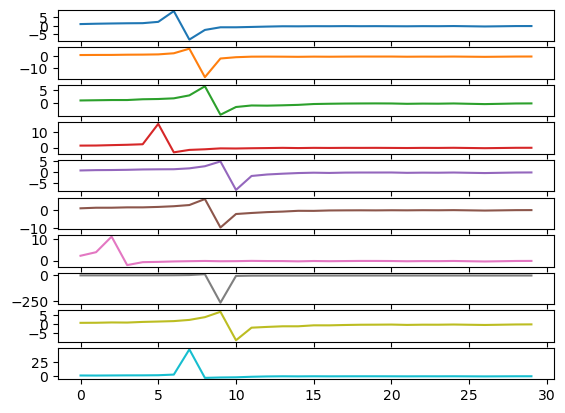

In [30]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i}': img[i,:] for i in range(n_units)})
df.plot(subplots=True, legend=False)

#### Threshold

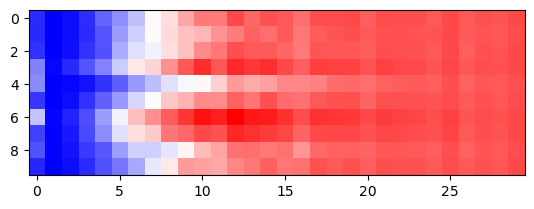

In [31]:
t = np.array(model.threshold_trace)
t = t.T
plt.imshow(t,cmap='bwr')

In [32]:
t.shape

(10, 30)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

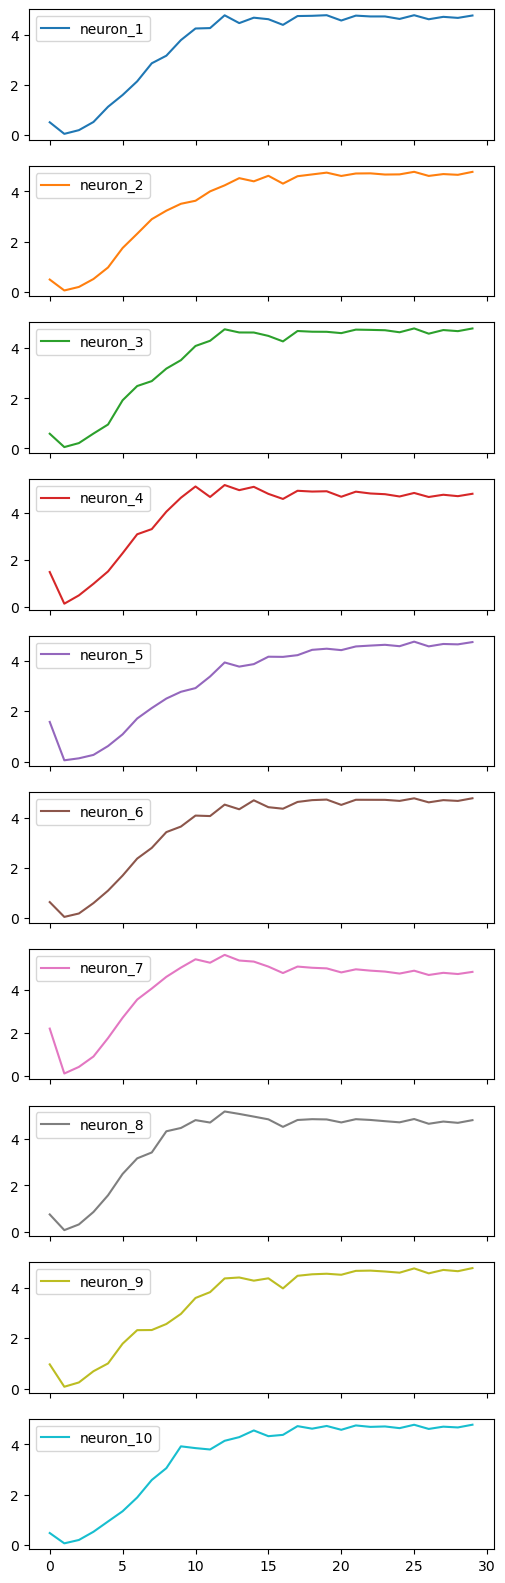

In [33]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i+1}': t[i, :] for i in range(n_units)})
df.plot(subplots=True, figsize=(6, n_units*2))


#### Activations

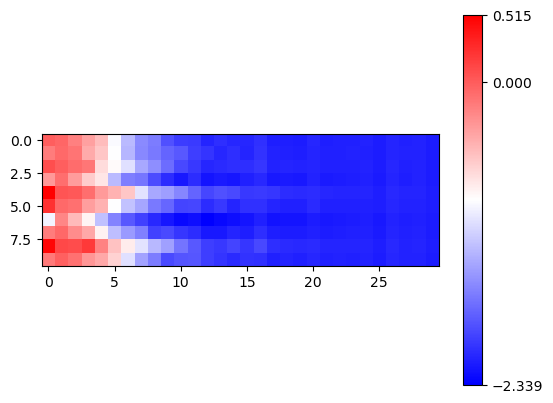

In [34]:
y = np.array(model.activations)
y = y.T
plt.imshow(y,cmap='bwr')
plt.colorbar( ticks=[np.amin(y), 0, np.amax(y)])

In [35]:
y.shape

(10, 30)

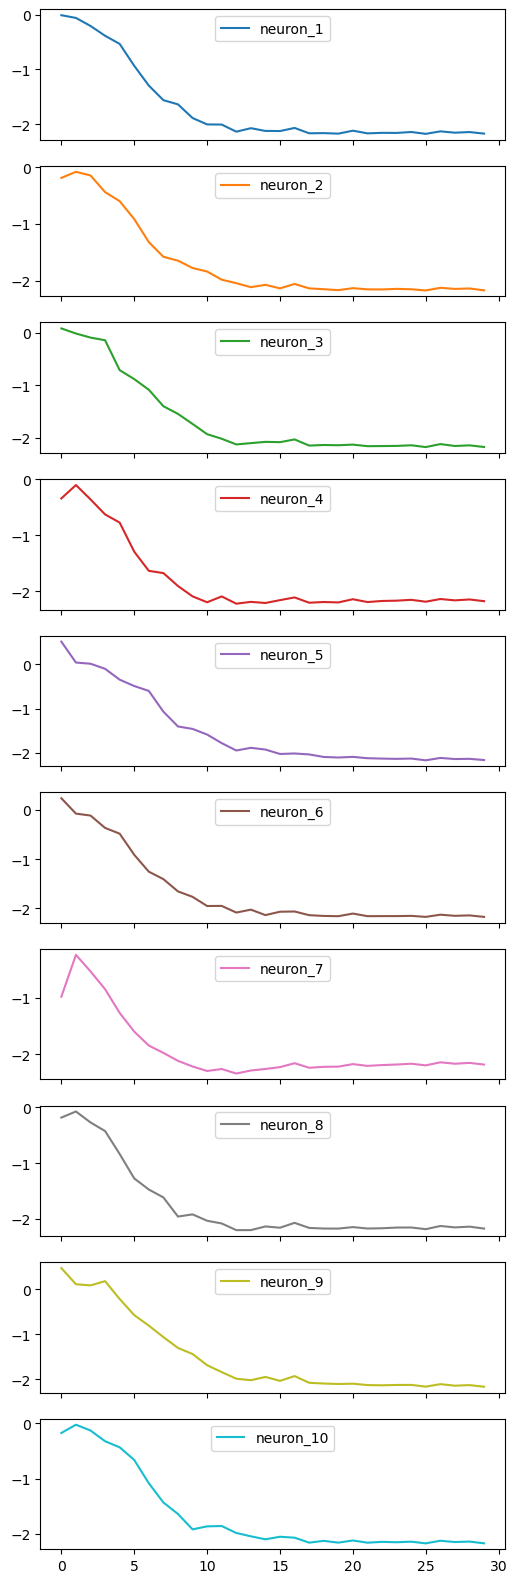

In [36]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i+1}': y[i, :] for i in range(n_units)})

# plot the data with subplots and assign the returned array
axes = df.plot(subplots=True,figsize=(6, n_units*2))

# flatten the array
axes = axes.flat  # .ravel() and .flatten() also work

# extract the figure object to use figure level methods

# iterate through each axes to use axes level methods
for ax in axes:
    
    ax.legend(loc='upper center', )
    


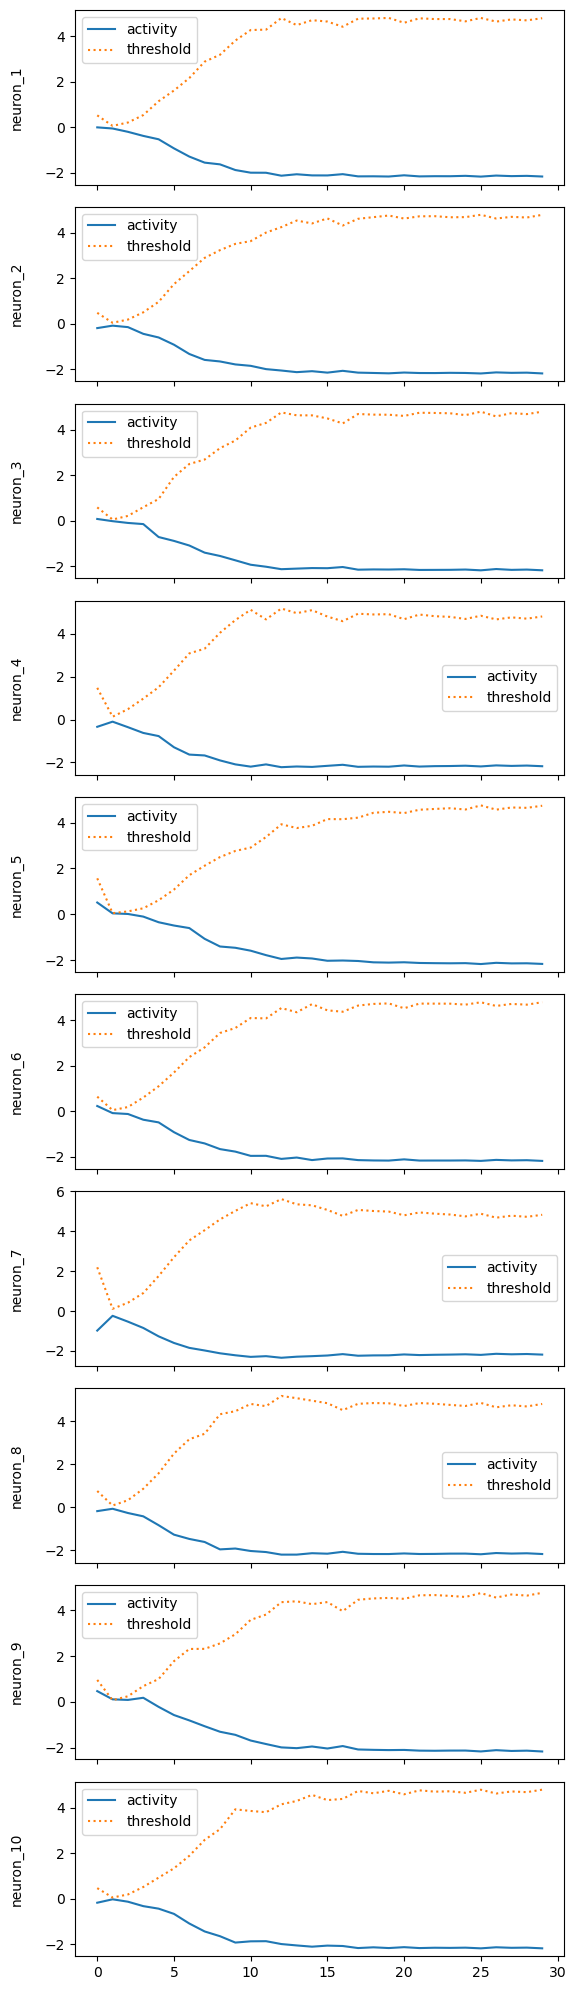

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming y and t are numpy arrays of shape (n_units, timepoints)
n_units = y.shape[0]

# Create subplots
fig, axes = plt.subplots(n_units, 1, figsize=(6, n_units*2), sharex=True)

# Loop over neurons
for i in range(n_units):
    ax = axes[i]
    
    # Plot activity
    ax.plot(y[i, :], label='activity')
    
    # Plot threshold (dotted)
    ax.plot(t[i, :], linestyle=':', label='threshold')
    
    # Set y-label as neuron label
    ax.set_ylabel(f'neuron_{i+1}', rotation=90, labelpad=20, va='center')
    
    # Optionally remove legend if labels are clear
    ax.legend()

plt.tight_layout()
plt.show()


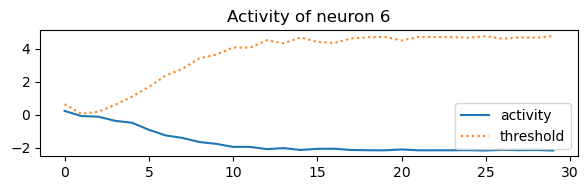

In [44]:
import matplotlib.pyplot as plt

# Select neuron index 5 (6th neuron)
i = 5

fig, ax = plt.subplots(figsize=(6, 2))

# Plot activity
ax.plot(y[i, :], label='activity')

# Plot threshold (dotted)
ax.plot(t[i, :], linestyle=':', label='threshold')

# Set y-label as neuron label
#x.set_ylabel(f'neuron_{i}', rotation=0, labelpad=40, va='center')
# Add legend
plt.title(f"Activity of neuron {i+1}")
ax.legend()

plt.tight_layout()
plt.show()


#### Comparing Threshold & Activity 

In [45]:
import seaborn as sns

In [46]:
y.shape

(10, 30)

In [47]:
y[i,:]

array([ 0.23464624, -0.07693602, -0.11610625, -0.36672554, -0.48346312,
       -0.9124664 , -1.25435014, -1.40562654, -1.65449218, -1.76452145,
       -1.95072217, -1.94846527, -2.08355348, -2.02431351, -2.13497305,
       -2.06638929, -2.06182664, -2.1366621 , -2.15197052, -2.15722263,
       -2.1040125 , -2.15665076, -2.15516907, -2.15520017, -2.15055375,
       -2.17098727, -2.12694727, -2.14957499, -2.14081182, -2.17160033])

In [48]:
t[i,:]

array([0.64325226, 0.05302633, 0.18884463, 0.60437917, 1.10000309,
       1.70004291, 2.377354  , 2.80351246, 3.43298626, 3.65347976,
       4.09105398, 4.0722944 , 4.52797492, 4.34254188, 4.69959911,
       4.4258258 , 4.36525244, 4.63520569, 4.70728975, 4.72943637,
       4.51729588, 4.7214476 , 4.71992659, 4.71857819, 4.67642602,
       4.77942784, 4.61855491, 4.70693807, 4.67563874, 4.78165813])

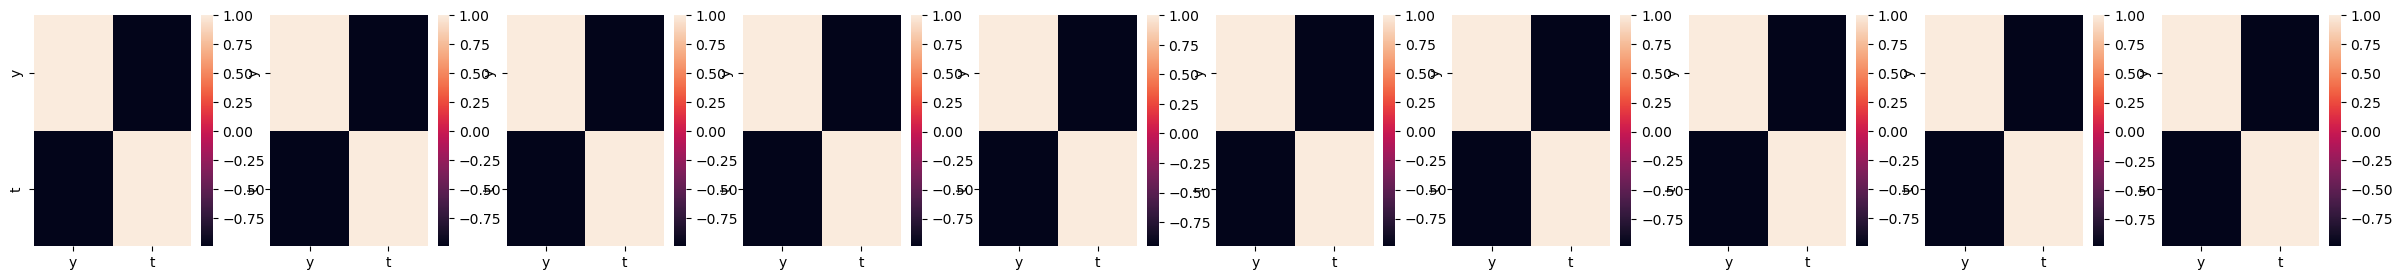

In [49]:
n_cols = n_units  # number of columns in subplot grid
n_rows = 1 # compute number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i in range(n_units):
    df = pd.DataFrame({'y':y[i,:], 't':t[i,:]})
    cor = df.corr()
    sns.heatmap(cor, ax= axes[i])